In [3]:
# Imports
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import cv2
from PIL import Image

from matplotlib.patches import Rectangle
from os import listdir
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns

In [4]:
DIRECTORY = "/kaggle/input/augmented-lfw/Augmented_LFW_final/Augmented_LFW_Final"

# Custom LFW Dataset
#### This is a subset of LFW (Labelled Faces in the wild dataset) with 50 subjects and 10 images of each subject, ensuring a robust set for training and testing. This dataset was designed to capture the diversity of gender with 20 females and 30 males and people from various ethnic backgrounds. 

# Exploratory Data Analysis


(250, 250, 3, 3)


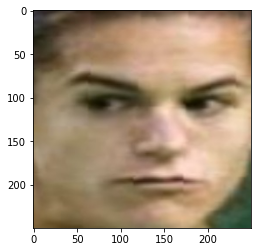

In [5]:
filename = "/kaggle/input/augmented-lfw/Augmented_LFW_final/Augmented_LFW_Final/Amelie_Mauresmo/1.jpg"
pixels = plt.imread(filename)

rgb_pixels = np.stack((pixels, pixels, pixels), axis=2)
print(rgb_pixels.shape)
plt.imshow(pixels)
plt.show()

# Building the dataset
We need to extract the faces for all of the images so that we can create our dataset for training/testing.

In [6]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


In [28]:
def load_dataset(directory):
    images = []
    labels = []
    for subdir in os.listdir(directory):
        # Path to subfolder
        folder_path = os.path.join(directory, subdir)
        
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                # Skip non-image files
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(folder_path, file)
                    img = load_img(img_path, target_size=(32, 32))
                    img = img_to_array(img)
                    img /= 255.0  # Normalize to [0, 1]
                    images.append(img)
                    labels.append(subdir)  # Subfolder name as label

    return np.array(images), np.array(labels)

# Base directory containing subfolders with images
base_dir = '/kaggle/input/augmented-lfw/Augmented_LFW_final/Augmented_LFW_Final'
images, labels = load_dataset(base_dir)


In [29]:
print(images.shape)
print(labels.shape)

(3408, 32, 32, 3)
(3408,)


In [30]:
print()

### Encoding and Splitting Dataset into Training and Validation Sets

In [31]:
# Encode labels into integers and then into one-hot vectors
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)
categorical_labels = to_categorical(encoded_labels)

# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(images, categorical_labels, test_size=0.2, random_state=42)

print(f'Training samples: {x_train.shape[0]}, Validation samples: {x_val.shape[0]}')


Training samples: 2726, Validation samples: 682


In [32]:
categorical_labels.shape

(3408, 50)

## Defining the CNN architecture

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Number of classes
num_classes = y_train.shape[1]

# Define the model
model = Sequential([
    # Convolutional layer 1
    Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    # Convolutional layer 2
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    # Flattening the 3D outputs to 1D
    Flatten(),
    
    # Fully connected Dense layer 1
    Dense(96, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    # Output layer
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
batch_normalization_9 (Batch (None, 30, 30, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 32)        18464     
_________________________________________________________________
batch_normalization_10 (Batc (None, 13, 13, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 6, 32)         

## Training the model for 25 epochs. 

In [35]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=25,  # You can adjust this number as required
    batch_size=32,  # Adjust the batch size according to your system's capabilities
    validation_data=(x_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/25
86/86 [==============================] - 2s 9ms/step - loss: 4.5141 - accuracy: 0.0504 - val_loss: 4.0103 - val_accuracy: 0.0205
Epoch 2/25
86/86 [==============================] - 1s 6ms/step - loss: 3.1973 - accuracy: 0.2127 - val_loss: 4.7562 - val_accuracy: 0.0528
Epoch 3/25
86/86 [==============================] - 1s 6ms/step - loss: 2.3694 - accuracy: 0.3826 - val_loss: 4.8583 - val_accuracy: 0.0367
Epoch 4/25
86/86 [==============================] - 1s 6ms/step - loss: 1.7718 - accuracy: 0.5444 - val_loss: 3.3187 - val_accuracy: 0.1554
Epoch 5/25
86/86 [==============================] - 1s 6ms/step - loss: 1.4448 - accuracy: 0.6331 - val_loss: 2.4714 - val_accuracy: 0.3519
Epoch 6/25
86/86 [==============================] - 1s 6ms/step - loss: 1.0427 - accuracy: 0.7595 - val_loss: 1.2362 - val_accuracy: 0.7786
Epoch 7/25
86/86 [==============================] - 1s 6ms/step - loss: 0.8977 - accuracy: 0.7842 - val_loss: 0.7749 - val_accuracy: 0.8842
Epoch 8/25
86/86 [==

## Plotting Loss and Accuracy Graphs

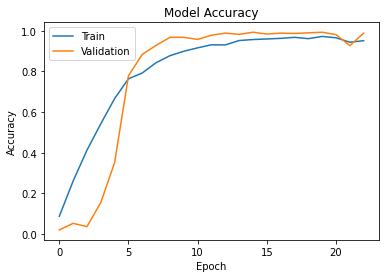

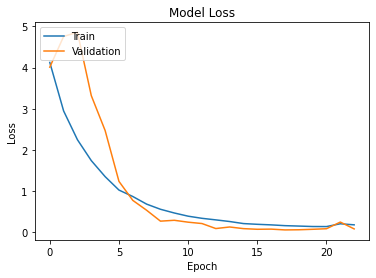

In [36]:
import matplotlib.pyplot as plt

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


## Evaluating the model 

In [37]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score


# Predict classes on the validation set
y_pred = model.predict(x_val, batch_size=32)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
report = classification_report(y_true, y_pred_classes, target_names=encoder.classes_)

accuracy_percentage = accuracy * 100

# Overall precision, recall, f1-score
overall_precision = precision_score(y_true, y_pred_classes, average='weighted')
overall_recall = recall_score(y_true, y_pred_classes, average='weighted')
overall_f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f'Overall Accuracy: {accuracy_percentage:.3f}%')
print(f'Overall Precision: {overall_precision:.3f}')
print(f'Overall Recall: {overall_recall:.3f}')
print(f'Overall F1-Score: {overall_f1:.3f}')

print(report)

Overall Accuracy: 98.680%
Overall Precision: 0.988
Overall Recall: 0.987
Overall F1-Score: 0.987
                        precision    recall  f1-score   support

       Amelie_Mauresmo       0.94      1.00      0.97        16
          Andre_Agassi       1.00      1.00      1.00        13
          Andy_Roddick       1.00      1.00      1.00         8
       Anna_Kournikova       1.00      1.00      1.00        12
         Ari_Fleischer       1.00      0.94      0.97        16
  Atal_Bihari_Vajpayee       1.00      1.00      1.00        14
          Bill_Clinton       0.94      1.00      0.97        16
        Britney_Spears       1.00      0.95      0.97        20
           Dick_Cheney       1.00      1.00      1.00        18
 Dominique_de_Villepin       1.00      1.00      1.00        18
          Fidel_Castro       1.00      1.00      1.00        15
           Halle_Berry       1.00      1.00      1.00         8
             Hans_Blix       1.00      1.00      1.00        13
      

### Checking Predictions on some random images. 

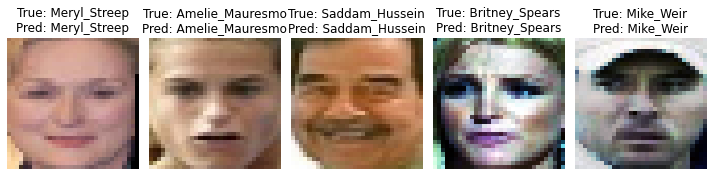

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display images, true labels, and predicted labels in a larger subplot
def display_images_with_predictions(images, true_labels, predicted_labels, encoder, num_images=5):
    indices = np.random.choice(range(len(images)), num_images)
    plt.figure(figsize=(num_images * 2, 4))

    for i, index in enumerate(indices):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[index])
        true_label = encoder.inverse_transform([np.argmax(true_labels[index])])[0]
        predicted_label = encoder.inverse_transform([predicted_labels[index]])[0]
        plt.title(f'True: {true_label}\nPred: {predicted_label}', fontsize=12)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Generate predictions for the images
predicted_probs = model.predict(x_val, batch_size=32)
predicted_classes = np.argmax(predicted_probs, axis=1)

# Display images with true and predicted labels
display_images_with_predictions(x_val, y_val, predicted_classes, encoder)


The face recognition model gives successful predictions, correctly identifying each individual from a diverse dataset. This accuracy highlights the model's robustness and effectiveness in real-world applications.

## Saving the model and Quantization by Tflite. 

In [40]:
model.save("/kaggle/working/LFW_model_32x32.h5")
print("Model saved")

Model saved


In [41]:
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model("/kaggle/working/LFW_model_64x64.h5")

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open("converted_model.tflite", "wb") as f:
    f.write(tflite_model)

model_path = "/kaggle/working/LFW_model_64x64.h5"
    # Get the size of the model in bytes
model_size = os.path.getsize(model_path)

# Print the size of the model in bytes
print(f"Model size: {model_size} bytes")

# Optionally, convert the size from bytes to megabytes
model_size_mb = model_size / (1024 * 1024)
print(f"Model size: {model_size_mb:.2f} MB")


Model size: 1708272 bytes
Model size: 1.63 MB


In [49]:
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model("/kaggle/working/LFW_model_32x32.h5")

# Convert the model to TensorFlow Lite format with post-training quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()
print("Debugging")
# Save the quantized TensorFlow Lite model
with open("quantized_model_32x32.tflite", "wb") as f:
    f.write(tflite_quantized_model)
    print("Quantized model saved.")

model_path = "/kaggle/working/quantized_model_32x32.tflite"
    # Get the size of the model in bytes
model_size = os.path.getsize(model_path)

# Print the size of the model in bytes
print(f"Model size: {model_size} bytes")

# Optionally, convert the size from bytes to megabytes
model_size_mb = model_size / (1024 * 1024)
print(f"Model size: {model_size_mb:.2f} MB")

Debugging
Quantized model saved.
Model size: 145424 bytes
Model size: 0.14 MB


In [45]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report

class TFLiteModel:
    def __init__(self, model_path):
        self.interpreter = tf.lite.Interpreter(model_path=model_path)
        self.interpreter.allocate_tensors()
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()

    def predict(self, x):
        # Initialize an array to store the predictions
        predictions = np.zeros((x.shape[0], self.output_details[0]['shape'][1]), dtype=np.float32)
        
        for i in range(x.shape[0]):
            # Set the value of the input tensor
            self.interpreter.set_tensor(self.input_details[0]['index'], x[i:i+1])
            # Run the inference
            self.interpreter.invoke()
            # Collect the result
            predictions[i] = self.interpreter.get_tensor(self.output_details[0]['index'])
        
        return predictions

# Usage
model = TFLiteModel("/kaggle/working/quantized_model_64x64.tflite")

# Ensure x_val is reshaped if necessary and preprocessed as required by the model
y_pred = model.predict(x_val)  # Predict for all images
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)  # Ensure y_val is the correct label array

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)*100
report = classification_report(y_true, y_pred_classes, target_names=encoder.classes_)

print(f'Overall Accuracy: {accuracy:.3f}%')

print("Classification Report:\n", report)


Overall Accuracy: 98.534%
Classification Report:
                         precision    recall  f1-score   support

       Amelie_Mauresmo       0.94      1.00      0.97        16
          Andre_Agassi       1.00      1.00      1.00        13
          Andy_Roddick       1.00      1.00      1.00         8
       Anna_Kournikova       1.00      1.00      1.00        12
         Ari_Fleischer       1.00      0.94      0.97        16
  Atal_Bihari_Vajpayee       1.00      1.00      1.00        14
          Bill_Clinton       0.94      1.00      0.97        16
        Britney_Spears       1.00      0.95      0.97        20
           Dick_Cheney       1.00      1.00      1.00        18
 Dominique_de_Villepin       1.00      1.00      1.00        18
          Fidel_Castro       1.00      1.00      1.00        15
           Halle_Berry       1.00      1.00      1.00         8
             Hans_Blix       1.00      1.00      1.00        13
       Hillary_Clinton       1.00      1.00      1.00

## Showing some of the predictions of the TFlite model. 

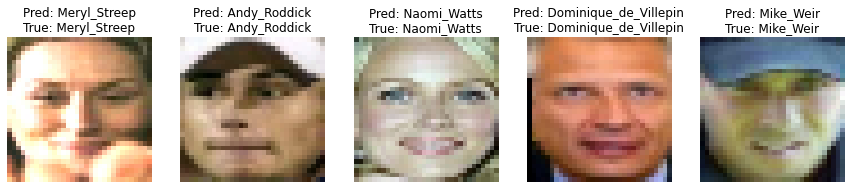

In [46]:
import matplotlib.pyplot as plt

# Function to plot images with predictions
def plot_images_with_labels(images, true_labels, pred_labels, class_names):
    plt.figure(figsize=(15, 3))
    for i in range(5):  
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].squeeze())
        plt.title(f"Pred: {class_names[pred_labels[i]]}\nTrue: {class_names[true_labels[i]]}")
        plt.axis('off')
    plt.show()

# Call the function to plot images
plot_images_with_labels(x_val[:5], y_true[:5], y_pred_classes[:5], encoder.classes_)


 The model is converted from a standard TensorFlow model into a TensorFlow Lite model with post-training quantization, significantly reducing its size by >90%. The new model is only 0.1MB and gives ~98% accuracy.This process enhances the model's deployability on resource-constrained devices, optimizing both storage and runtime efficiency, crucial for embedded and mobile applications.